In [ ]:
# Install dependencies if necessary
!pip install nltk

# Import essentials
import pandas as pd
import numpy as np
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Load the datasets
true_df = pd.read_csv('/content/drive/MyDrive/Collab Uploads/True.csv')
fake_df = pd.read_csv('/content/drive/MyDrive/Collab Uploads/Fake.csv')

# Add labels
true_df['label'] = 0  # Real news
fake_df['label'] = 1  # Fake news

# Combine them
df = pd.concat([true_df, fake_df], axis=0).sample(frac=1).reset_index(drop=True)

# Display basic info
print(df.head())
print(f"Dataset shape: {df.shape}")

                                               title  \
0  Senator Rubio: Hackers targeted former preside...   
1  White House does not yet have plan on debt lim...   
2  'There's no going back,' Zimbabwe ruling party...   
3  Slain Philippine teenager's family files murde...   
4   Trump Tweets Deranged, Self-Congratulatory ‘F...   

                                                text       subject  \
0  WASHINGTON (Reuters) - U.S. Senator Marco Rubi...  politicsNews   
1  WASHINGTON (Reuters) - The White House has not...  politicsNews   
2  JOHANNESBURG (Reuters) - Leaders of Zimbabwe s...     worldnews   
3  MANILA (Reuters) - The parents and lawyers of ...     worldnews   
4  Trump s ongoing meltdown over  fake news  (the...          News   

                 date  label  
0     March 30, 2017       0  
1      June 15, 2017       0  
2  November 17, 2017       0  
3    August 25, 2017       0  
4    January 18, 2017      1  
Dataset shape: (44898, 5)


In [ ]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['clean_text'])
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize base models
rf = RandomForestClassifier(n_estimators=200, random_state=42)
dt = DecisionTreeClassifier(random_state=42)
lr = LogisticRegression(max_iter=300, solver='lbfgs', random_state=42)

# Create ensemble (Voting) classifier
ensemble = VotingClassifier(
    estimators=[('rf', rf), ('dt', dt), ('lr', lr)],
    voting='hard'
)

# Train ensemble model
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=42)),
                             ('dt', DecisionTreeClassifier(random_state=42)),
                             ('lr',
                              LogisticRegression(max_iter=300,
                                                 random_state=42))])


Classification Report:

              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      4268
        Fake       1.00      1.00      1.00      4712

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Accuracy: 99.78%


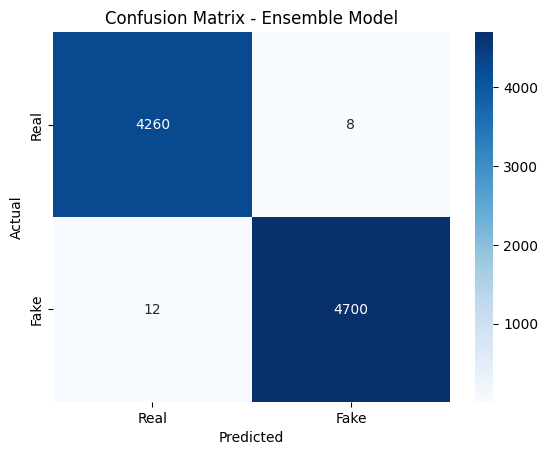

In [ ]:
# Predictions
y_pred = ensemble.predict(X_test)

# Evaluation metrics
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Ensemble Model")
plt.show()

In [ ]:
def predict_news(article):
    cleaned = clean_text(article)
    vectorized = tfidf.transform([cleaned])
    prediction = ensemble.predict(vectorized)
    return "Fake News ❌" if prediction[0] == 1 else "Real News ✅"

# Example usage:
news_sample = "WASHINGTON (Reuters) - U.S. Secretary of State Rex Tillersonâ€™s expected exit from the  Trump administration is one of many staff changes likely as President Donald Trump nears the end of his first year in office, with sources saying top economic adviser Gary Cohn and  son-in-law Jared Kushner could be among those who depart. Cohn, whose relationship with Trump became tense earlier this year, has considered leaving once the Republican effort to overhaul the U.S. tax system is completed in Congress, according to the sources with ties to the White House who spoke on condition of anonymity. Kushner, who has seen his influence in the White House shrink, may receive a â€œface-savingâ€ exit as he deals with legal challenges related to a special counselâ€™s investigation of Trumpâ€™s 2016 presidential campaignâ€™s potential ties to Russia, one of the sources said. â€œThis is pure speculation,â€ said White House spokesman Raj Shah in an emailed statement about potential staff moves. More junior-level advisers could also use the completion of Trumpâ€™s first year and tax legislation as a pivot point to move on, leading to another period of uncertainty that has at times overshadowed Trumpâ€™s tenure, which began on Jan. 20. Things change quickly at the Trump White House. Advisers and Cabinet members who fall out of favor with the president can re-enter his good graces, making it hard to predict staff moves. But shifts in personnel are watched around the world for indications of how Trump will tackle issues ranging from North Korea to regulatory policy. â€œIt may be February, it may be March, it may be April, but I think once you get to that time period, people are going to feel as though theyâ€™ve kind of put their time in,â€ said one person with close ties to the White House. â€œYouâ€™re definitely going to see some people leave after tax cuts get done,â€ said a separate Trump adviser, who requested anonymity to speak freely about the administration. Trump is considering a plan to oust Tillerson, whose relationship has been strained by the top U.S. diplomatâ€™s softer line on North Korea and other differences, senior administration officials said. A State Department spokeswoman said Tillersonâ€™s chief of staff had been told by the White House that the reports of Tillerson being replaced were not true. Cohnâ€™s future in the White House has come into question since his public criticism of Trumpâ€™s response to the violence at a white supremacist rally in Virginia in August. Their once-tense relationship has since improved, however, and one source close to the White House said he could stay longer to help spearhead legislation to improve U.S. infrastructure. â€œIâ€™d go a little bit against conventional wisdom here and say heâ€™s got one more project to get under his belt before he leaves,â€ the source said, referring to infrastructure. The White House noted Cohnâ€™s interview with CNBC earlier this month in which said he did not plan to leave after tax reform was finished. â€œItâ€™s my plan to stay and work as long as I can help the president drive his economic agenda,â€ Cohn said. Two of the sources with ties to the White House said they assumed the White House chief of staff, General John Kelly, wanted at least to outlast his predecessor Reince Priebusâ€™ six-month tenure in the position. The White House spokesmanâ€™s statement said discussion of changes was speculation.   One of the sources said Kushner, who is married to Trumpâ€™s daughter Ivanka Trump, could go if a scenario, such as giving him an outside adviser role, were found that appealed to the president. â€œOnce someone comes up with a solution that sounds right, then I think heâ€™s going to latch on,â€ the source said. Kushner told the Washington Post this month that he and his wife, a fellow White House adviser, were â€œhere to stay.â€ Though a lot of speculation about departures has focused on high-profile names, the possibility of mid-level staffers leaving could have a big impact on the rhythms of the White House. â€œThe difference in this administration is that you donâ€™t have replacements already on staffâ€ or people clamoring to get on board, said one of the sources with ties to the White House. "
print(predict_news(news_sample))

Real News ✅
